## Task 5: Regularized Regression (Ridge & Lasso)

### Objective
The goal of this task is to **apply Regularized Regression techniques** to improve sales forecasting accuracy by reducing overfitting and identifying which features contribute the most to predictions.

---

### What We Will Do

1. **Implement Ridge Regression**  
   - Adds *L2 regularization* to stabilize coefficients and handle multicollinearity.

2. **Implement Lasso Regression**  
   - Uses *L1 regularization* to shrink less important feature weights to zero, making the model more interpretable.

3. **Compare Against Linear / Multiple Regression (Baseline Model)**  
   - Benchmark performance without regularization to see if Ridge/Lasso actually improves forecasting.

4. **Identify Important Features**  
   - Use **Lasso coefficients** to determine which features contribute the most to store sales.

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.set_option('display.max_columns', 200)

In [3]:
train = pd.read_csv(r"C:\Users\Deepti\Downloads\train.csv",parse_dates=["date"])
print("Loaded train shape:", train.shape)
train.head()

Loaded train shape: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
print(train.info())
print("\nMissing values per column:\n", train.isna().sum())
print("\nSales summary:")
print(train['sales'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

Missing values per column:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Sales summary:
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64


In [5]:
df = train.copy()

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['onpromotion'] = df['onpromotion'].astype(int)
df[['date','store_nbr','family','sales','onpromotion','year','month','dayofweek']].head()

,date,store_nbr,family,sales,onpromotion,year,month,dayofweek
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1


In [6]:
le_store = LabelEncoder()
le_family = LabelEncoder()

df['store_encoded'] = le_store.fit_transform(df['store_nbr'])
df['family_encoded'] = le_family.fit_transform(df['family'])
print("Unique stores:", df['store_nbr'].nunique(), "->", df['store_encoded'].nunique())
print("Unique families:", df['family'].nunique(), "->", df['family_encoded'].nunique())
df[['store_nbr','store_encoded','family','family_encoded']].head()

Unique stores: 54 -> 54
Unique families: 33 -> 33


,store_nbr,store_encoded,family,family_encoded
0,1,0,AUTOMOTIVE,0
1,1,0,BABY CARE,1
2,1,0,BEAUTY,2
3,1,0,BEVERAGES,3
4,1,0,BOOKS,4


In [9]:
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
group_cols = ['store_nbr', 'family']

df['lag_7'] = df.groupby(group_cols)['sales'].shift(7)
df['rolling_mean_7'] = df.groupby(group_cols)['sales'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())

for c in ['lag_7', 'rolling_mean_7']:
    df[c] = df.groupby(group_cols)[c].transform(lambda x: x.fillna(x.median()))
    df[c] = df[c].fillna(df[c].median())

df[['date','store_nbr','family','sales','lag_7','rolling_mean_7']].head(10)

,date,store_nbr,family,sales,lag_7,rolling_mean_7
0,2013-01-01,1,AUTOMOTIVE,0.0,3.0,3.142857
1,2013-01-02,1,AUTOMOTIVE,2.0,3.0,0.000000
2,2013-01-03,1,AUTOMOTIVE,3.0,3.0,1.000000
3,2013-01-04,1,AUTOMOTIVE,3.0,3.0,1.666667
4,2013-01-05,1,AUTOMOTIVE,5.0,3.0,2.000000
5,2013-01-06,1,AUTOMOTIVE,2.0,3.0,2.600000
6,2013-01-07,1,AUTOMOTIVE,0.0,3.0,2.500000
7,2013-01-08,1,AUTOMOTIVE,2.0,0.0,2.142857
8,2013-01-09,1,AUTOMOTIVE,2.0,2.0,2.428571
9,2013-01-10,1,AUTOMOTIVE,2.0,3.0,2.428571


In [12]:
feature_cols = [ 'store_encoded', 'family_encoded', 'onpromotion','year','month','day','dayofweek','is_weekend', 'lag_7','rolling_mean_7']
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].copy()
y = df['sales'].copy()

split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx].reset_index(drop=True)
X_val   = X.iloc[split_idx:].reset_index(drop=True)
y_train = y.iloc[:split_idx].reset_index(drop=True)
y_val   = y.iloc[split_idx:].reset_index(drop=True)

print("Train rows:", X_train.shape[0], "Validation rows:", X_val.shape[0])

Train rows: 2400710 Validation rows: 600178


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols)

X_train_scaled.head()

,store_encoded,family_encoded,onpromotion,year,month,day,dayofweek,is_weekend,lag_7,rolling_mean_7
0,-1.69212,-1.670266,-0.219317,-1.365698,-1.538209,-1.663488,-0.998147,-0.632324,-0.333781,-0.350429
1,-1.69212,-1.670266,-0.219317,-1.365698,-1.538209,-1.549784,-0.498332,-0.632324,-0.333781,-0.354177
2,-1.69212,-1.670266,-0.219317,-1.365698,-1.538209,-1.436081,0.001484,-0.632324,-0.333781,-0.352985
3,-1.69212,-1.670266,-0.219317,-1.365698,-1.538209,-1.322377,0.501299,-0.632324,-0.333781,-0.352190
4,-1.69212,-1.670266,-0.219317,-1.365698,-1.538209,-1.208673,1.001114,1.581468,-0.333781,-0.351792


In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ridge = Ridge(max_iter=5000)
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 50, 100]}

ridge_gs = GridSearchCV(ridge, param_grid_ridge, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
ridge_gs.fit(X_train_scaled, y_train)

print("Best Ridge alpha:", ridge_gs.best_params_)

y_pred_ridge = ridge_gs.predict(X_val_scaled)

def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

metrics_ridge = eval_metrics(y_val, y_pred_ridge)
print("Ridge metrics on validation:", metrics_ridge)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Ridge alpha: {'alpha': 0.01}
Ridge metrics on validation: {'RMSE': np.float64(512.221095026024), 'MAE': 139.95514641245143, 'R2': 0.9091322745594282}


In [15]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=5000)
param_grid_lasso = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

lasso_gs = GridSearchCV(lasso, param_grid_lasso, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
lasso_gs.fit(X_train_scaled, y_train)

print("Best Lasso alpha:", lasso_gs.best_params_)

y_pred_lasso = lasso_gs.predict(X_val_scaled)
metrics_lasso = eval_metrics(y_val, y_pred_lasso)
print("Lasso metrics on validation:", metrics_lasso)

lasso_best = lasso_gs.best_estimator_
coef = lasso_best.coef_
coef_df = pd.DataFrame({'feature': feature_cols, 'coefficient': coef})
coef_df['abs_coeff'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coeff', ascending=False).reset_index(drop=True)

print("\nTop features by absolute Lasso coefficient:")
print(coef_df.head(15))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Lasso alpha: {'alpha': 0.1}
Lasso metrics on validation: {'RMSE': np.float64(512.1603909691039), 'MAE': 139.77027455316477, 'R2': 0.9091538110122376}

Top features by absolute Lasso coefficient:
          feature  coefficient   abs_coeff
0  rolling_mean_7   544.111496  544.111496
1           lag_7   280.044027  280.044027
2     onpromotion    40.612907   40.612907
3      is_weekend    36.630530   36.630530
4       dayofweek   -10.819591   10.819591
5            year    -6.416209    6.416209
6             day    -5.561249    5.561249
7           month     2.370885    2.370885
8  family_encoded    -1.866736    1.866736
9   store_encoded    -0.962769    0.962769


In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)
metrics_lr = eval_metrics(y_val, y_pred_lr)
print("Linear Regression metrics on validation:", metrics_lr)

Linear Regression metrics on validation: {'RMSE': np.float64(512.2210963536818), 'MAE': 139.95514767447298, 'R2': 0.9091322740883768}


    model        RMSE         MAE        R2
0   Ridge  512.221095  139.955146  0.909132
1   Lasso  512.160391  139.770275  0.909154
2  Linear  512.221096  139.955148  0.909132

Best model by RMSE: Lasso


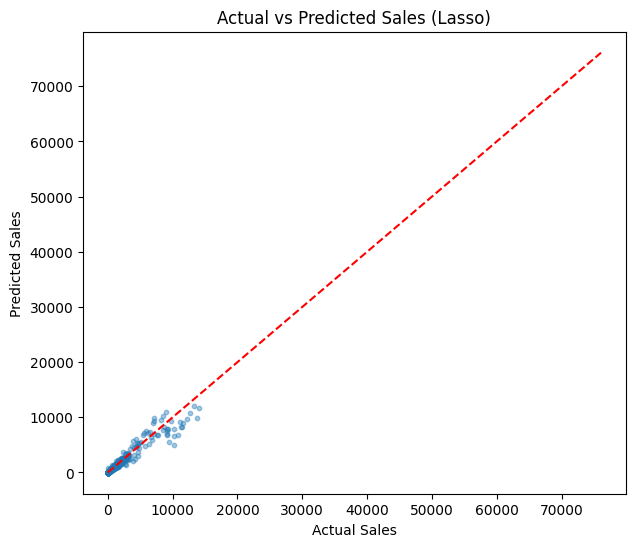

In [18]:
results = pd.DataFrame([{'model':'Ridge', **metrics_ridge},{'model':'Lasso', **metrics_lasso},{'model':'Linear', **metrics_lr}])
print(results)

best_row = results.loc[results['RMSE'].idxmin()]
best_model_name = best_row['model']
print("\nBest model by RMSE:", best_model_name)

preds_map = {'Ridge': y_pred_ridge, 'Lasso': y_pred_lasso, 'Linear': y_pred_lr}
best_preds = preds_map[best_model_name]

rng = np.random.default_rng(seed=42)
sample_size = min(1000, len(y_val))
sample_idx = rng.choice(len(y_val), size=sample_size, replace=False)

plt.figure(figsize=(7,6))
plt.scatter(y_val.iloc[sample_idx], best_preds[sample_idx], alpha=0.4, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted Sales ({best_model_name})')
plt.show()

Top 15 features by Lasso (absolute coefficient):
          feature  coefficient   abs_coeff
0  rolling_mean_7   544.111496  544.111496
1           lag_7   280.044027  280.044027
2     onpromotion    40.612907   40.612907
3      is_weekend    36.630530   36.630530
4       dayofweek   -10.819591   10.819591
5            year    -6.416209    6.416209
6             day    -5.561249    5.561249
7           month     2.370885    2.370885
8  family_encoded    -1.866736    1.866736
9   store_encoded    -0.962769    0.962769

Top 15 features by Ridge (absolute coefficient):
          feature  coefficient   abs_coeff
0  rolling_mean_7   544.626526  544.626526
1           lag_7   279.537394  279.537394
2     onpromotion    40.747956   40.747956
3      is_weekend    37.155019   37.155019
4       dayofweek   -11.319968   11.319968
5            year    -6.538034    6.538034
6             day    -5.659863    5.659863
7           month     2.444987    2.444987
8  family_encoded    -1.956393    1.95639

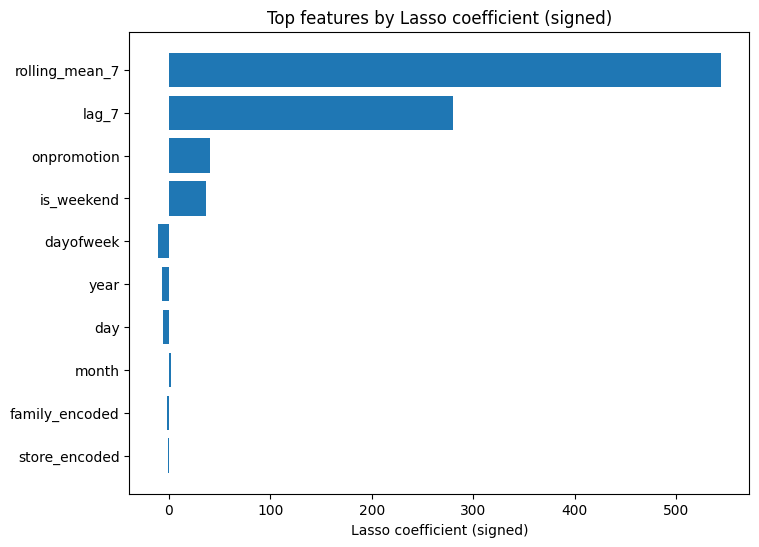

In [19]:
print("Top 15 features by Lasso (absolute coefficient):")
print(coef_df.head(15))

ridge_best = ridge_gs.best_estimator_
ridge_coef_df = pd.DataFrame({'feature': feature_cols, 'coefficient': ridge_best.coef_})
ridge_coef_df['abs_coeff'] = ridge_coef_df['coefficient'].abs()
ridge_coef_df = ridge_coef_df.sort_values('abs_coeff', ascending=False).reset_index(drop=True)

print("\nTop 15 features by Ridge (absolute coefficient):")
print(ridge_coef_df.head(15))

topn = 10
plt.figure(figsize=(8,6))
subset = coef_df.head(topn).iloc[::-1]   # reverse for horizontal bar plot
plt.barh(subset['feature'], subset['coefficient'])
plt.xlabel('Lasso coefficient (signed)')
plt.title('Top features by Lasso coefficient (signed)')
plt.show()